In [1]:
pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████████████████▉            | 316.3 MB 19.5 MB/s eta 0:00:11ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 319, in run
    reqs, check_supported_wheels=not options.target_dir
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 128, in resolve
    requirements, max_rounds=try_to_avoid_resolution_too_deep
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 473, in resolve
    state = resolution.resolve(requirements, max_rounds=m

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
print("Processing......")


Processing......


In [3]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

print("Processing.....")

Processing.....


In [4]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [5]:
df = df.sort_values('Date')

In [6]:
df.head(10)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42
5,2010-07-21,0.07921,0.08181,0.05050,0.05050,0.05050,129
6,2010-07-22,0.05050,0.06767,0.05050,0.06262,0.06262,141
7,2010-07-23,0.06262,0.06161,0.05049,0.05454,0.05454,26
8,2010-07-24,0.05454,0.05941,0.05050,0.05050,0.05050,85
9,2010-07-25,0.05050,0.05600,0.05000,0.05600,0.05600,46


In [7]:
df.shape

(3201, 7)

Text(0, 0.5, 'Close Price (USD)')

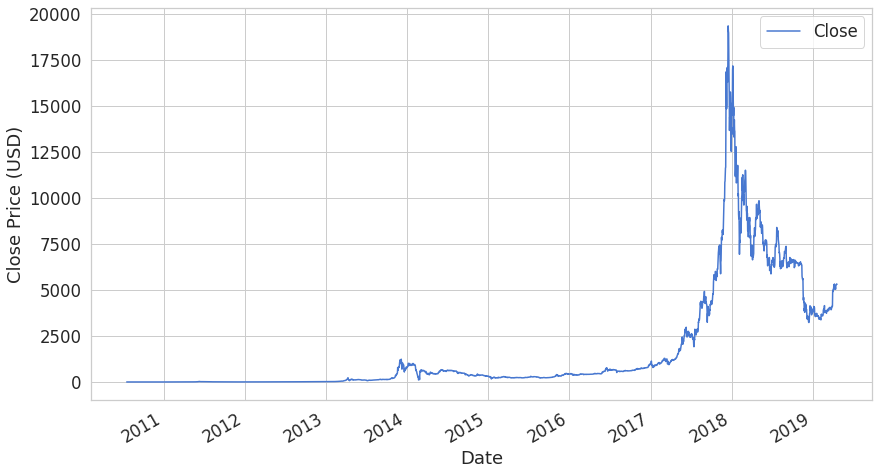

In [8]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [9]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [10]:
scaled_close.shape

(3201, 1)

In [11]:
np.isnan(scaled_close).any()

False

In [12]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [13]:
scaled_close = scaled_close.reshape(-1, 1)

In [14]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [15]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [16]:
X_train.shape

(2945, 99, 1)

In [17]:
X_test.shape

(156, 99, 1)

# Model

In [18]:
DROPOUT = 0.2
## drops out some nodes of the network here 20% of nodes are dropout to avoid overfitting.

WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()
##Implements the sequential model approach.

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
##Showing the bidirectional nature of LSTM showing both direction Backward(future to past) or Forward(past to future).

model.add(Dropout(rate=DROPOUT))
##  Dropout is a technique where randomly selected neurons are ignored during training.


model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
 ## WindOW_SIZE-----------used to set the size of the  window.
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))                  #To add a hidden layer

model.add(Activation('linear'))            # Add linear Activation fuction 

# Training

In [21]:
model.compile(
    loss='mse', 
    optimizer='adam',
)

In [22]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=5, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/5
42/42 [==============================] - 11s 87ms/step - loss: 0.0011 - val_loss: 0.0336
Epoch 2/5
42/42 [==============================] - 2s 48ms/step - loss: 0.0071 - val_loss: 0.0029
Epoch 3/5
42/42 [==============================] - 2s 54ms/step - loss: 0.0128 - val_loss: 0.0289
Epoch 4/5
42/42 [==============================] - 2s 41ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 5/5
42/42 [==============================] - 2s 42ms/step - loss: 0.0037 - val_loss: 0.0062


In [23]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 25ms/step - loss: 0.0040


0.003951031714677811

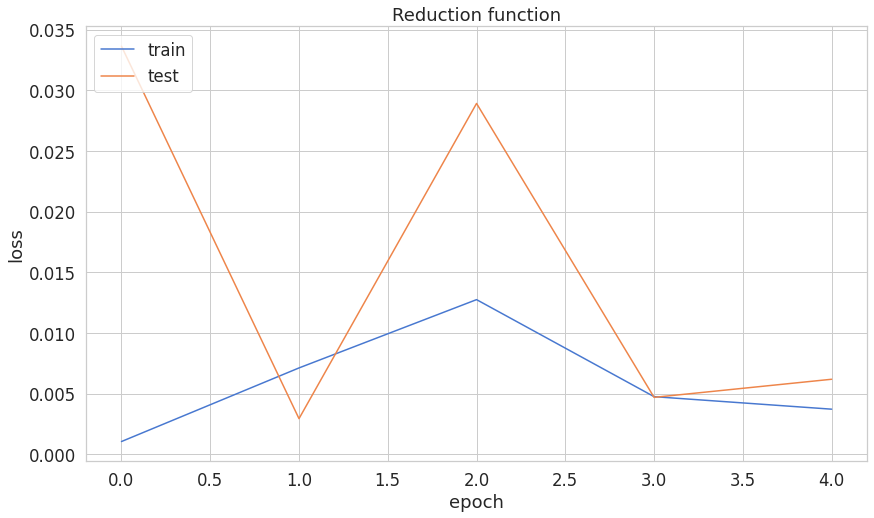

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Reduction function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

[[5586.27002 ]
 [5568.939941]
 [5615.259766]
 [4809.620117]
 [4441.810059]
 [4593.040039]
 [4320.680176]
 [4343.419922]
 [3854.110107]
 [4004.149902]
 [3784.590088]
 [3822.98999 ]
 [4263.549805]
 [4286.689941]
 [4009.669922]
 [4197.459961]
 [4143.859863]
 [3871.409912]
 [3948.439941]
 [3737.530029]
 [3485.179932]
 [3420.570068]
 [3461.070068]
 [3592.840088]
 [3467.159912]
 [3401.02002 ]
 [3485.590088]
 [3305.110107]
 [3235.47998 ]
 [3232.51001 ]
 [3255.370117]
 [3548.189941]
 [3715.850098]
 [3736.540039]
 [4137.660156]
 [3898.810059]
 [4045.23999 ]
 [4007.629883]
 [4081.949951]
 [3834.72998 ]
 [3848.780029]
 [3646.090088]
 [3947.860107]
 [3797.060059]
 [3896.209961]
 [3747.389893]
 [3880.149902]
 [3961.01001 ]
 [3835.860107]
 [3874.060059]
 [3855.389893]
 [4102.850098]
 [4050.399902]
 [4040.75    ]
 [4048.340088]
 [3668.149902]
 [3669.199951]
 [3664.379883]
 [3551.23999 ]
 [3703.899902]
 [3621.23999 ]
 [3643.98999 ]
 [3685.300049]
 [3648.050049]
 [3729.780029]
 [3567.72998 ]
 [3571.919

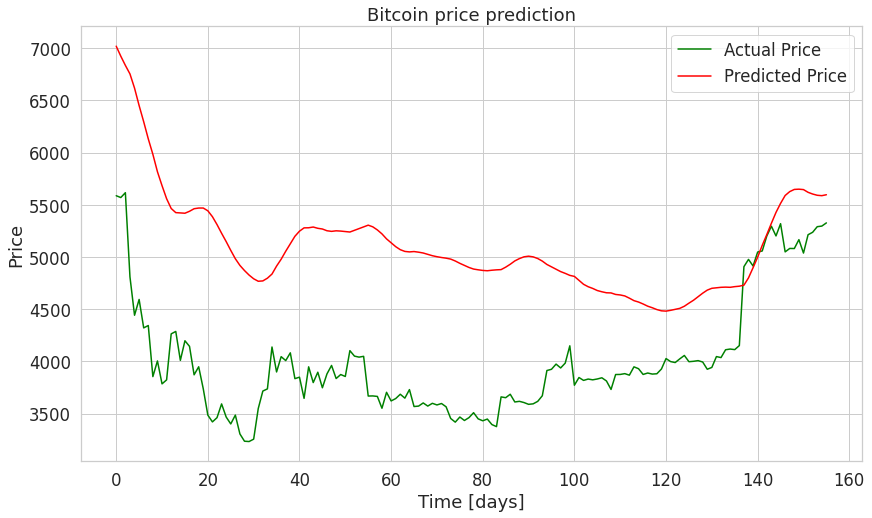

In [30]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

print(y_test_inverse) 
print(y_hat_inverse)
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [33]:
from matplotlib.image import PcolorImage
import matplotlib.pyplot as plt
import numpy as np
#remove_nan_targets = targets.dropna()
investmentvalue=remove_nan_targets.iloc[0]
oldarray = np.array([0])
for value in remove_nan_targets.items():
    pc=(investmentvalue/value[1])/100
    ypoints = np.append(oldarray, pc)
    print(pc)
    print(ypoints)
plt.title('Growth')
plt.xlabel('Growth Percentage')
plt.ylabel('Growth Value')
plt.plot(ypoints, linestyle = 'dashed')
plt.show()


NameError: ignored